# Persistent Homology using Ripser
- Input: embedding (downsampled or raw) pickle file
- Output: dgms (list of np arrays per dimension/homology group rank)

notes:
- stimulus key: cex=color exchange, dg=drifting gratings, cg=chromatic gratings, lf=luminance flash

Author: @emilyekstrum
<br> 11/17/25

In [ ]:
import numpy as np
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from ripser import ripser
import random
from pathlib import Path
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from persim import plot_diagrams
import seaborn as sns

## Load in data

In [ ]:
# Load in data
def load_embedding_data(filepath):
    """Loads in embedding stored in pickle file
    See CEBRA_embeddings.ipynb or PCA_UMAP.ipynb for more specific details on how these embeddings were saved to pickle files
    Args:
        filepath : str path to the pickle file.
    Returns:
        single_session_dict : dict with session names as keys and embeddings as values
        session_names : list of session names"""
    
    with open(filepath, "rb") as f:
        single_session_dict = pkl.load(f)
        session_names = list(single_session_dict.keys())
        
    return single_session_dict, session_names

## Downsample embeddings

In [ ]:
#randomly downsample embeddings
def downsample_embedding(embed, n_target=1000, seed=42): 
    """Downsamples embedding to n_target points using random sampling without replacement.
    Args:
        embed : np.ndarray of shape (N, D) where N is number of points and D is embedding dimension.
        n_target : int, target number of points after downsampling.
    Returns:
        downsampled_embed : np.ndarray of shape (n_target, D) if N > n_target, else original embed."""
    
    embed = np.asarray(embed, dtype=np.float32)
    N = embed.shape[0]
    if N <= n_target:
        return embed
    rng = np.random.default_rng(seed)
    idx = rng.choice(N, size=n_target, replace=False)
    print("Downsampling done")
    return embed[idx]

In [ ]:
def fps_downsample_embedding(embed, n_target=1000, method="fps", seed=42):
    """Downsamples embedding to n_target points using either random sampling or Farthest Point Sampling (FPS).
    Args:
        embed : np.ndarray of shape (N, D) where N is number of points and D is embedding dimension.
        n_target : int, target number of points after downsampling.
        method : str, either "random" or "fps" to specify downsampling method.
    Returns:
        downsampled_embed : np.ndarray of shape (n_target, D) if N > n_target, else original embed."""
    
    N = embed.shape[0]
    print(N)
    if n_target >= N:
        return embed  
    
    rng = np.random.default_rng(seed)

    if method == "random":
        idx = rng.choice(N, size=n_target, replace=False)
        return embed[idx]

    elif method == "fps":
        idxs = [rng.integers(N)]
        dists = np.linalg.norm(embed - embed[idxs[0]], axis=1)

        for _ in range(1, n_target):
            next_idx = np.argmax(dists)
            idxs.append(next_idx)
            new_dists = np.linalg.norm(embed - embed[next_idx], axis=1)
            dists = np.minimum(dists, new_dists)

        return embed[idxs]

    else:
        raise ValueError("method must be 'random' or 'fps'")

In [ ]:
# Embedding to KNN sparse matrix
def knn_sparse_dist(embedding, n_neighbors=300, metric="euclidean", plot = False, plot_title= " "):
    """Makes symmetric KNN sparse distance matrix -> input for ripser
       Can also plot heatmap of distance matrix subset
       
    Args:
        embedding : np.ndarray of shape (N, D) where N is number of points and D is embedding dimension.
        n_neighbors : int, number of nearest neighbors to consider for each point.
        metric : str, distance metric to use (default is "euclidean").
        plot : bool, whether to plot heatmap of distance matrix subset.
        plot_title : str, title for the heatmap plot.
    Returns:
        sparse_matrix : scipy.sparse.csr_matrix of shape (N, N) representing the symmetric KNN distance matrix."""
    
    nn = NearestNeighbors(n_neighbors=n_neighbors, metric=metric, n_jobs=-1)
    nn.fit(embedding)
    distances, indices = nn.kneighbors(embedding, return_distance=True)        
    num_samples = embedding.shape[0]
    rows = np.repeat(np.arange(num_samples), n_neighbors)
    cols = indices.ravel()
    vals = distances.ravel().astype(np.float32)

    sparse_matrix = csr_matrix((vals, (rows, cols)), shape=(num_samples, num_samples))
    # Symmetrize with min distance on shared edges
    sparse_matrix = sparse_matrix.minimum(sparse_matrix.transpose())

    if plot == True:
        m = min(600, sparse_matrix.shape[0])
        dense_sub = sparse_matrix[:m, :m]
        mask_sub = (dense_sub == 0)

        sns.heatmap(dense_sub, mask=mask_sub, cmap='viridis', square=True, cbar_kws ={'label' : 'Distance'})
        plt.title(plot_title)
        plt.show()
    return sparse_matrix

In [ ]:
# Ripser
def tda_ripser(distance_matrix, name, maxdim=2, region='LGN', dims=3, stim = "cex", embed_type = "CEBRA", plot = False):
    """ Computes persistence diagrams and optionally plots them.
    
    Args:
        distance_matrix : np.ndarray or scipy.sparse matrix representing the distance matrix.
        name : str, name of the dataset/session.
        maxdim : int, maximum homology dimension to compute (default is 2).
        region : str, brain region (default is 'LGN').
        dims : int, embedding dimension (default is 3).
        stim : str, stimulus type (default is "cex").
        embed_type : str, type of embedding (default is "CEBRA").
        plot : bool, whether to plot the persistence diagrams (default is False).
    Returns:
        dgms : list of np.ndarray, persistence diagrams for each homology dimension."""

    dgms = ripser(distance_matrix, distance_matrix=True, maxdim=maxdim)['dgms']

    if plot == True:
        plot_diagrams(dgms, title=(f"Persistence Diagram of {name} - {stim}"), show=True)

    
    return dgms

1997


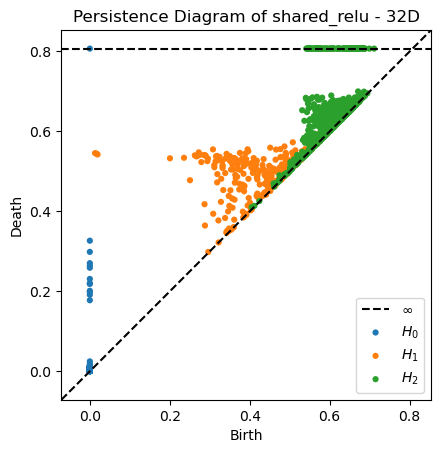

In [ ]:
if __name__ =="__main__":
    # parameters
    embedding_path =(r"C:\Users\denmanlab\Desktop\Emily_rotation\nick_CNN_data\32d_shared_relu_CEBRA_embed.pkl") #path to embedding
    embed_type = "CEBRA" # CEBRA or PCA_UMAP
    name = ["shared_relu"] # mouse ID / session name keys in embedding pickle file
    dims = 3 #dims of embedding
    stim = "DG" # stimulus type
    maxdim = 2 # homology groups **note increasing this significantly increases computation time. You should downsample embeddings if using dim > 1
    region = "LGN" # LGN or V1

    #KNN matrix
    n_neighbors = 300 
    matrix_metric = 'cosine'
    plot_matrix = False
    matrix_plot_title = " "

    #Ripser
    plot_dgms = False # to plot persistence diagram

# Loop through embeddings & run TDA
for n,name in enumerate(name):
    session = pd.read_pickle(embedding_path)
    embedding = session[name]['embedding']

    ds_embedding = fps_downsample_embedding(embedding, n_target=10000)

    sparse_matrix = knn_sparse_dist(ds_embedding, n_neighbors, matrix_metric, plot_matrix,
                                    matrix_plot_title)

    dgms = tda_ripser(sparse_matrix, name, maxdim, region, dims, stim, embed_type, plot=True)

    # save persistence diagram profile to pickle file
    with open(r"C:\Users\denmanlab\Desktop\Emily_rotation\nick_CNN_data\32d_shared_relu_dgms.pkl", 'wb') as f:
        pkl.dump(dgms, f)
    

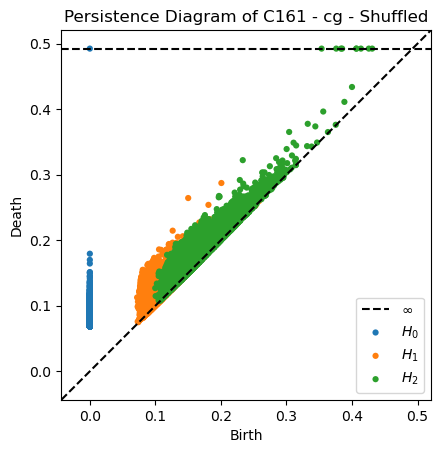

In [19]:
# check to make sure persistence diagrams are right

with open(r"C:\Users\denmanlab\Desktop\Emily_rotation\Ripser\CEBRA_shuffled\32d\V1_32d_shuffled_chromatic_gratings_C161_dgms.pkl", 'rb') as f:
    dgms = pkl.load(f)

from persim import plot_diagrams
plot_diagrams(dgms, title="Persistence Diagram of C161 - cg - Shuffled", show=True)

In [ ]:
# option to load in npy data
shared_relu = np.load(r"C:\Users\denmanlab\Desktop\Emily_rotation\nick_CNN_data\shared_relu.npy")

In [ ]:
# get dgms directly from npy data without preprocessing (KNN dist matrix & downsampling)
dgms = ripser(shared_relu, distance_matrix=False, maxdim=2)['dgms']